In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

signal = pd.read_pickle("SignalMC.pkl")
bkgnd = pd.read_pickle("sidebands.pkl")

In [47]:
signal['signal/bkgnd'] = 1
bkgnd['signal/bkgnd'] = 0

In [48]:
#merge signal+bkgnd in one file
df = pd.concat([signal,bkgnd], ignore_index=True)

In [49]:
df.head(5)

,Bpt,kpt,PDL,prob,BMass,DiMuMass,cosA,signLxy,signal/bkgnd
0,26.680304,11.619227,0.021847,0.748338,5.312783,3.538398,0.999972,15.482615,1
1,10.257165,3.517378,0.018031,0.967825,5.333508,1.616260,0.993626,7.343916,1
2,17.177292,2.610023,0.075210,0.086362,5.291852,4.585297,0.999993,45.554184,1
3,20.117249,3.583837,0.038395,0.333149,5.231747,2.684836,0.999318,24.436850,1
4,45.658031,4.257549,0.007641,0.372221,5.256309,4.134099,0.999891,7.496773,1


In [50]:
#remove the mass columns
df = df.drop(['BMass', 'DiMuMass'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14758 entries, 0 to 14757
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Bpt           14758 non-null  float32
 1   kpt           14758 non-null  float32
 2   PDL           14758 non-null  float32
 3   prob          14758 non-null  float32
 4   cosA          14758 non-null  float32
 5   signLxy       14758 non-null  float32
 6   signal/bkgnd  14758 non-null  int64  
dtypes: float32(6), int64(1)
memory usage: 461.3 KB


In [51]:
#GENERAL DATA
train_x = df.drop(['signal/bkgnd'], axis=1) #features = all minus signal/bkgnd
train_y = df['signal/bkgnd'] #label = signal/bkgnd

In [52]:
#SIGNAL
signal_x = signal.drop(['signal/bkgnd','BMass', 'DiMuMass'], axis=1)
signal_y = signal['signal/bkgnd']

In [53]:
#BKGND
bkgnd_x = bkgnd.drop(['signal/bkgnd','BMass', 'DiMuMass'], axis=1)
bkgnd_y = bkgnd['signal/bkgnd']

In [54]:
#SAMPLING DATA
#GENERAL
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

#SIGNAL
train_signal_x, test_signal_x, train_signal_y, test_signal_y = train_test_split(signal_x, signal_y, 
                                                  test_size=0.2, 
                                                  random_state=1)
#BKGND
train_bkgnd_x, test_bkgnd_x, train_bkgnd_y, test_bkgnd_y = train_test_split(bkgnd_x, bkgnd_y, 
                                                  test_size=0.2, 
                                                  random_state=1)

In [55]:
#GENERAL DATA INPUT FUNCTIONS

#train input function
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=train_x,
                                                               y=train_y,
                                                               num_epochs=None,
                                                               batch_size=100,
                                                               shuffle=True)

#test function
test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=test_x,
                                                             y=test_y,
                                                              num_epochs=1,
                                                              batch_size=
                                                             len(test_x),
                                                              shuffle=False)


In [56]:
#SIGNAL INPUT FUNCTIONS

#create input function
train_signal_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=train_signal_x,
                                                               y=train_signal_y,
                                                               num_epochs=None,
                                                               batch_size=100,
                                                               shuffle=True)

#validation function
test_signal_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=test_signal_x,
                                                             y=test_signal_y,
                                                              num_epochs=1,
                                                              batch_size=
                                                             len(test_signal_x),
                                                              shuffle=False)

In [57]:
#BKGND INPUT FUNCTIONS

#create input function
train_bkgnd_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=train_bkgnd_x,
                                                               y=train_bkgnd_y,
                                                               num_epochs=None,
                                                               batch_size=100,
                                                               shuffle=True)

#validation function
test_bkgnd_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(x=test_bkgnd_x,
                                                             y=test_bkgnd_y,
                                                              num_epochs=1,
                                                              batch_size=
                                                             len(test_bkgnd_x),
                                                              shuffle=False)

In [58]:
#FEATURE COLUMNS

Bpt = tf.feature_column.numeric_column("Bpt")
kpt = tf.feature_column.numeric_column("kpt")
PDL = tf.feature_column.numeric_column("PDL")
prob = tf.feature_column.numeric_column("prob")
signLxy = tf.feature_column.numeric_column("signLxy")
cosA = tf.feature_column.numeric_column("cosA")

ft_columns = [Bpt, kpt, PDL, prob, signLxy, cosA]

In [59]:
#DNN

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = tf.estimator.DNNClassifier(feature_columns=ft_columns,
                                   hidden_units=[35,20], 
                                   n_classes=2, 
                                   optimizer=optimizer)
                                  

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplcccq9pr', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [60]:
model.train(input_fn=train_input_fn, steps=100)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmplcccq9pr/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.455706, step = 0
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100...
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmplcccq9pr/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100...
INFO:tensorflow:Loss for final step: 0.5173733.


In [61]:
accuracy_score = model.evaluate(input_fn=test_signal_fn)["accuracy"]
print("\nTest accuracy: {0:f}%\n".format(accuracy_score*100))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-06-10T22:35:04Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplcccq9pr/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.88964s
INFO:tensorflow:Finished evaluation at 2020-06-10-22:35:04
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.77100843, accuracy_baseline = 1.0, auc = 0.0, auc_precision_recall = 1.0, average_loss = 0.48128372, global_step = 100, label/mean = 1.0, loss = 0.48128372, precision = 1.0, prediction/mean = 0.6943087, recall = 0.77100843
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmplcccq9pr/model.ckpt-100

Test accuracy: 77.100843%



In [66]:
LABEL =['YOU DIED', 'YOU LIVED']
list_prob_signal = []
predictions = model.predict(input_fn=test_signal_fn)
for i, predict in enumerate(predictions):
    list_prob_signal.append(predict['probabilities'][1])
    label_ = predict['class_ids'][0]
    probs = predict['probabilities'][label_]
    print(f'Prediction \t{LABEL[label_]} ({100*probs} %) ')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplcccq9pr/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction 	YOU LIVED (96.3972270488739 %) 
Prediction 	YOU LIVED (81.67710900306702 %) 
Prediction 	YOU LIVED (70.87591290473938 %) 
Prediction 	YOU LIVED (78.66838574409485 %) 
Prediction 	YOU LIVED (83.70298743247986 %) 
Prediction 	YOU DIED (82.09537267684937 %) 
Prediction 	YOU LIVED (64.93875980377197 %) 
Prediction 	YOU DIED (58.02491307258606 %) 
Prediction 	YOU LIVED (58.55010151863098 %) 
Prediction 	YOU LIVED (96.02633118629456 %) 
Prediction 	YOU LIVED (97.92680740356445 %) 
Prediction 	YOU DIED (75.56336522102356 %) 
Prediction 	YOU DIED (90.02196788787842 %) 
Prediction 	YOU LIVED (65.3319776058197 %) 
Prediction 	YOU LIVED (95.99926471710205 %) 
Prediction 	YOU LIVED (70.36321759223938 %) 
Prediction 	YOU LIV

Prediction 	YOU DIED (51.595646142959595 %) 
Prediction 	YOU LIVED (81.00597858428955 %) 
Prediction 	YOU LIVED (68.2649552822113 %) 
Prediction 	YOU LIVED (63.19909691810608 %) 
Prediction 	YOU LIVED (53.785669803619385 %) 
Prediction 	YOU LIVED (82.49776363372803 %) 
Prediction 	YOU LIVED (88.7730360031128 %) 
Prediction 	YOU LIVED (95.17497420310974 %) 
Prediction 	YOU DIED (81.98848962783813 %) 
Prediction 	YOU DIED (68.17850470542908 %) 
Prediction 	YOU LIVED (77.6850700378418 %) 
Prediction 	YOU LIVED (64.81063961982727 %) 
Prediction 	YOU LIVED (99.9714195728302 %) 
Prediction 	YOU LIVED (79.47868704795837 %) 
Prediction 	YOU LIVED (55.653172731399536 %) 
Prediction 	YOU LIVED (60.01342535018921 %) 
Prediction 	YOU LIVED (81.82585835456848 %) 
Prediction 	YOU LIVED (55.30809760093689 %) 
Prediction 	YOU LIVED (90.01266360282898 %) 
Prediction 	YOU LIVED (77.85397171974182 %) 
Prediction 	YOU LIVED (68.52284669876099 %) 
Prediction 	YOU LIVED (62.97091245651245 %) 
Prediction 	YO

In [67]:
LABEL =['YOU DIED', 'YOU LIVED']
list_prob_bkgnd = []
predictions2 = model.predict(input_fn=test_bkgnd_fn)
for i, predict in enumerate(predictions2):
    list_prob_bkgnd.append(predict['probabilities'][1])
    label_ = predict['class_ids'][0]
    probs = predict['probabilities'][label_]
    print(f'Prediction \t{LABEL[label_]} ({100*probs} %) ')

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplcccq9pr/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prediction 	YOU DIED (78.51382493972778 %) 
Prediction 	YOU LIVED (59.91845726966858 %) 
Prediction 	YOU DIED (95.81409096717834 %) 
Prediction 	YOU DIED (73.7358808517456 %) 
Prediction 	YOU DIED (61.71645522117615 %) 
Prediction 	YOU DIED (78.31764817237854 %) 
Prediction 	YOU LIVED (52.44302153587341 %) 
Prediction 	YOU DIED (81.40111565589905 %) 
Prediction 	YOU DIED (56.30028247833252 %) 
Prediction 	YOU DIED (65.71768522262573 %) 
Prediction 	YOU LIVED (59.95166897773743 %) 
Prediction 	YOU DIED (71.6049313545227 %) 
Prediction 	YOU DIED (71.32552862167358 %) 
Prediction 	YOU DIED (75.08598566055298 %) 
Prediction 	YOU DIED (82.76740312576294 %) 
Prediction 	YOU DIED (83.98650884628296 %) 
Prediction 	YOU DIED (73.209

Prediction 	YOU DIED (76.54828429222107 %) 
Prediction 	YOU DIED (52.454566955566406 %) 
Prediction 	YOU DIED (83.65573287010193 %) 
Prediction 	YOU DIED (81.65429830551147 %) 
Prediction 	YOU DIED (78.79174947738647 %) 
Prediction 	YOU DIED (70.14403343200684 %) 
Prediction 	YOU DIED (79.56417798995972 %) 
Prediction 	YOU DIED (58.454447984695435 %) 
Prediction 	YOU DIED (71.73112034797668 %) 
Prediction 	YOU DIED (80.93148469924927 %) 
Prediction 	YOU LIVED (74.6550440788269 %) 
Prediction 	YOU DIED (74.84694719314575 %) 
Prediction 	YOU DIED (65.45102596282959 %) 
Prediction 	YOU DIED (53.394508361816406 %) 
Prediction 	YOU DIED (72.57727384567261 %) 
Prediction 	YOU DIED (52.52462029457092 %) 
Prediction 	YOU DIED (80.32821416854858 %) 
Prediction 	YOU LIVED (91.57510995864868 %) 
Prediction 	YOU DIED (85.45898795127869 %) 
Prediction 	YOU DIED (64.86191153526306 %) 
Prediction 	YOU DIED (73.65880012512207 %) 
Prediction 	YOU DIED (72.41190075874329 %) 
Prediction 	YOU DIED (60.038

Prediction 	YOU DIED (66.47013425827026 %) 
Prediction 	YOU DIED (76.80639624595642 %) 
Prediction 	YOU DIED (64.42082524299622 %) 
Prediction 	YOU DIED (78.82195711135864 %) 
Prediction 	YOU LIVED (55.75306415557861 %) 
Prediction 	YOU DIED (75.07501244544983 %) 
Prediction 	YOU DIED (76.78523659706116 %) 
Prediction 	YOU DIED (71.07520699501038 %) 
Prediction 	YOU DIED (78.92598509788513 %) 
Prediction 	YOU DIED (63.270509243011475 %) 
Prediction 	YOU DIED (61.572521924972534 %) 
Prediction 	YOU DIED (54.83078360557556 %) 
Prediction 	YOU DIED (81.4293622970581 %) 
Prediction 	YOU DIED (86.74959540367126 %) 
Prediction 	YOU DIED (78.44190001487732 %) 
Prediction 	YOU LIVED (51.04380249977112 %) 
Prediction 	YOU DIED (72.63609766960144 %) 
Prediction 	YOU LIVED (54.471004009246826 %) 
Prediction 	YOU LIVED (71.33036851882935 %) 
Prediction 	YOU DIED (75.79973936080933 %) 
Prediction 	YOU DIED (59.807729721069336 %) 
Prediction 	YOU DIED (78.59334945678711 %) 
Prediction 	YOU DIED (70.

Prediction 	YOU DIED (78.63013744354248 %) 
Prediction 	YOU DIED (87.452632188797 %) 
Prediction 	YOU LIVED (69.02948021888733 %) 
Prediction 	YOU DIED (97.075754404068 %) 
Prediction 	YOU DIED (72.98721671104431 %) 
Prediction 	YOU DIED (71.50882482528687 %) 
Prediction 	YOU DIED (75.97782015800476 %) 
Prediction 	YOU DIED (76.38108730316162 %) 
Prediction 	YOU DIED (61.68839931488037 %) 
Prediction 	YOU DIED (63.727355003356934 %) 
Prediction 	YOU DIED (76.4159083366394 %) 
Prediction 	YOU DIED (78.55330109596252 %) 
Prediction 	YOU DIED (79.88995909690857 %) 
Prediction 	YOU DIED (82.88490772247314 %) 
Prediction 	YOU DIED (76.40618681907654 %) 
Prediction 	YOU DIED (78.98265719413757 %) 
Prediction 	YOU DIED (76.64119601249695 %) 
Prediction 	YOU DIED (78.00823450088501 %) 
Prediction 	YOU LIVED (62.196511030197144 %) 
Prediction 	YOU DIED (84.09724235534668 %) 
Prediction 	YOU DIED (84.81616377830505 %) 
Prediction 	YOU DIED (72.3086416721344 %) 
Prediction 	YOU DIED (50.906664133

Text(0.5, 1.0, 'Results using a DNN')

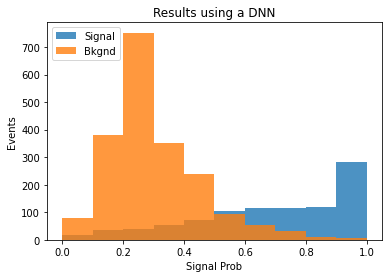

In [68]:
plt.hist(list_prob_signal, range=(0,1), alpha=0.8,label='Signal')
plt.hist(list_prob_bkgnd, range=(0,1), alpha=0.8, label='Bkgnd')
plt.legend(loc='upper left')
plt.xlabel('Signal Prob')
plt.ylabel('Events')
plt.title('Results using a DNN')

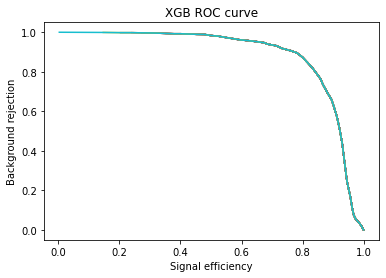

In [69]:
#CREEMOS DATOS ALEADORIOS Y ORDENEMOLOS DE MENOR A MAYOR

list_prob_signal = sorted(list_prob_signal)
list_prob_bkgnd = sorted(list_prob_bkgnd)

#LISTAS DONDE SE GUARDARAN LOS VALORES DE EFICIENCIA Y BACK_REJECTION
efficiency = []
background_rejection = []

#ITERAMOS SOBRE UN FLOAT QUE VA DE 0 A 100 EN 1000 PASOS
for cut in np.linspace(0,1, 50):
    
    #INICIALIZAMOS EL VALOR DE VIVOS ACEPTADOS Y MUERTOS RECHAZADOS
    #PUES EN EL CORTE = 0 ACEPTAMOS TODOS LOS 1s Y RECHAZAMOS TODOS LOS 0s
    accepted_signal = len(list_prob_signal)
    rejected_background = 0


    for i, v in enumerate(list_prob_signal):
        # YA QUE LAS LISTAS ESTAN ORDENADAS BASTA CON CHECAR EL PRIMER VALOR QUE 
        # SEA MAYOR QUE EL CORTE
        if cut<=v:
            accepted_signal-=i
            break
        #EN EL CASO DE QUE EL CORTE SEA MAYOR QUE TODAS LAS PROBS CONSIDERA QUE 
        # NINGUN VIVO FUE ACEPTADO
        if i==len(list_prob_signal)-1:
            accepted_signal=0

    # ANALOGAMENTE PARA LOS MUERTOS        
    for i, m in enumerate(list_prob_bkgnd):
        if cut<=m:
            rejected_background+=i
            break
        if i==len(list_prob_bkgnd)-1:
            rejected_background=len(list_prob_bkgnd)
    
    #ALMACENA EN LA LISTA
    efficiency.append(accepted_signal/len(list_prob_signal))
    background_rejection.append(rejected_background/len(list_prob_bkgnd))

    xgbst = plt.plot(efficiency, background_rejection)
    plt.xlabel('Signal efficiency')
    plt.ylabel('Background rejection')
    plt.title('DNN ROC curve')



In [1]:
model_predict1 = model.predict_proba(test_x)
model_predict1 = model_predict1[:,1]
auc_score1 = roc_auc_score(test_y, model_predict1)
fpr1, tpr1, _ = roc_curve(test_y, model_predict1)
testp = plt.plot(tpr1, 1-fpr1, label='test')
print('ROC AUC= ', auc_score1)
plt.show()

NameError: name 'model' is not defined